In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import calibration
import sklearn.linear_model
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
import numpy as np
import scipy.stats
from sklearn.base import clone
from sklearn.model_selection._search import ParameterSampler
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
os.chdir('/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability')

In [2]:
odds_df = pd.read_parquet("data/odds_data.parquet")
event_df = pd.read_parquet("data/event_data.parquet")

In [3]:
odds_df = odds_df.drop_duplicates("game_code")

In [4]:
df = event_df.merge(odds_df, how="inner", on=["game_code"], copy=False, suffixes=["", "_y"])

In [5]:
df.columns

Index(['game_code', 'game_date', 'home_team_id', 'away_team_id',
       'home_final_score', 'away_final_score', 'home_team_outcome',
       'off_team_id', 'off_team_name', 'off_team_abbrev', 'off_team_nickname',
       'def_team_id', 'def_team_name', 'def_team_abbrev', 'def_team_nickname',
       'play_unique_id', 'nevent', 'event_id', 'event_name', 'eff_cnts',
       'quarter', 'home_rest_of_game_score', 'away_rest_of_game_score',
       'home_team_has_ball', 'home_start_score', 'home_end_score',
       'away_start_score', 'away_end_score', 'off_start_score',
       'off_end_score', 'def_start_score', 'def_end_score', 'yd_from_goal',
       'is_twomin', 'from_scrimmage', 'is_first_down', 'is_scoring_play',
       'continuation', 'drive_id', 'drive_start', 'down', 'ytg',
       'time_of_score', 'total_play_yd', 'timeouts_left', 'unit', 'league_id',
       'league_name', 'off_conference_id', 'off_conference_name', 'season_id',
       'season', 'game_type_id', 'game_type_desc', 'def_conf

In [6]:
FEATURES = ['home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'play_start_time', 'yd_from_goal', 'from_scrimmage', 'down', 'ytg','cur_spread', 'cur_over_under']
TARGET = 'home_team_outcome'
CATEGORICALS = ['home_team_has_ball', 'quarter', 'from_scrimmage', 'down']

In [7]:
df = df[df["home_team_outcome"]!="T"]

In [8]:
train_df = df[df["season"]<=2016]
test_df = df[(df["season"]>=2017) & (df["season"]<=2019)]
val_df = df[df["season"]>=2020]


In [9]:
df[["home_team_outcome", "game_code"]].groupby("home_team_outcome").count()

,game_code
home_team_outcome,
L,290766
W,368634


In [10]:
FIT_PARAMS = {
    "verbose": 10,
    "early_stopping_rounds": 5,
    "use_best_model": True,
}
val_pool = Pool(
    val_df[FEATURES],
    val_df[TARGET],
    # weight=1 - (self.val_df["timeremaining"] / 2880),
    cat_features=CATEGORICALS,
)
FIT_PARAMS["eval_set"] = val_pool
COMPUTE_PARAMS = (
    {"devices": "0:1", "thread_count": -1}
)
PARAMS = {
    # "n_estimators": 10,
    "num_trees": 10000,
    "auto_class_weights": "Balanced",
    # "loss_function": JITRmseObjective(),
    # "eval_metric": JITRmseMetric(),
    **COMPUTE_PARAMS,
}


In [11]:
clf = CatBoostClassifier(
            random_state=42,
            **PARAMS,
            cat_features=CATEGORICALS,
)
clf.fit(train_df[FEATURES], train_df[TARGET], **FIT_PARAMS)

Learning rate set to 0.051388
0:	learn: 0.6698338	test: 0.6706906	best: 0.6706906 (0)	total: 175ms	remaining: 29m 5s
10:	learn: 0.5431568	test: 0.5425156	best: 0.5425156 (10)	total: 1.99s	remaining: 30m 9s
20:	learn: 0.5000461	test: 0.4981161	best: 0.4981161 (20)	total: 3.18s	remaining: 25m 13s
30:	learn: 0.4822495	test: 0.4812946	best: 0.4812946 (30)	total: 4.63s	remaining: 24m 50s
40:	learn: 0.4709152	test: 0.4731417	best: 0.4729904 (39)	total: 6.11s	remaining: 24m 43s
50:	learn: 0.4633854	test: 0.4666410	best: 0.4666410 (50)	total: 7.59s	remaining: 24m 41s
60:	learn: 0.4563477	test: 0.4623415	best: 0.4623415 (60)	total: 9.14s	remaining: 24m 49s
70:	learn: 0.4515995	test: 0.4599384	best: 0.4599384 (70)	total: 10.5s	remaining: 24m 35s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4592181928
bestIteration = 73

Shrink model to first 74 iterations.


In [12]:
test_df[['p_L', 'p_W']] = clf.predict_proba(test_df[FEATURES])

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [23]:
np.mean(test_df["p_L"])

0.48202623968544095

In [25]:
X = test_df[['game_code', 'nevent','p_W']+FEATURES]

In [14]:
pd.DataFrame(FEATURES, clf.feature_importances_)

,0
1.296765,home_team_has_ball
38.393390,home_start_score
31.111561,away_start_score
0.000000,quarter
0.019899,play_start_time
0.638822,yd_from_goal
0.000000,from_scrimmage
0.000000,down
0.000000,ytg
21.257598,cur_spread


In [15]:
def uniform_distribution(lo, hi):
    return scipy.stats.uniform(lo, hi - lo)

CATBOOST_CLF_PARAM_DISTRIBUTIONS = {
    "learning_rate": uniform_distribution(0.01, 0.1),
    "max_depth": range(5, 16),
    "subsample": uniform_distribution(0.9, 1),
    "l2_leaf_reg": uniform_distribution(1, 4),
    "boosting_type": ["Plain"],
    # 'l2_leaf_reg': [1.1128231580542005],
    # "learning_rate": [0.07497988950401423],
    # "max_depth":[15],
    # "subsample":[0.8424678221356553],
}


In [32]:
def ProbaScoreProxy(y_true, y_probs, proxied_func, **kwargs):
    return proxied_func(y_true, y_probs, **kwargs)
brier_scorer = make_scorer(
    ProbaScoreProxy,
    greater_is_better=False, #True
    needs_proba=True,
    proxied_func=brier_score_loss,
)
game_cv = GroupKFold(n_splits=3)
HPO_PARAMS={"n_jobs":1}
clf_new = CatBoostClassifier(
            random_state=42,
            **PARAMS,
            cat_features=CATEGORICALS,
)

hpo_search = RandomizedSearchCV(
    clf_new,
    CATBOOST_CLF_PARAM_DISTRIBUTIONS,
    n_iter=10,
    cv=game_cv,
    verbose=1,
    refit=False,
    scoring=brier_scorer,
    random_state=42,
    **HPO_PARAMS,
)
val_pool = Pool(
    val_df[FEATURES],
    val_df[TARGET],
    # weight=1 - (self.val_df["timeremaining"] / 2880),
    cat_features=CATEGORICALS,
)
FIT_PARAMS["eval_set"] = val_pool


In [33]:
hpo_search.fit(
    train_df[FEATURES],
    y=train_df[TARGET],
    groups=train_df["game_code"].values,
    **FIT_PARAMS,
)
import os
os.system('say "done"')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6261876	test: 0.6311041	best: 0.6311041 (0)	total: 1.49s	remaining: 4h 8m 22s
10:	learn: 0.4095907	test: 0.4882600	best: 0.4882600 (10)	total: 10.8s	remaining: 2h 43m 29s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.48497094
bestIteration = 14

Shrink model to first 15 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6255432	test: 0.6342533	best: 0.6342533 (0)	total: 935ms	remaining: 2h 35m 51s
10:	learn: 0.4114709	test: 0.4827564	best: 0.4816728 (9)	total: 9.16s	remaining: 2h 18m 37s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4738336506
bestIteration = 14

Shrink model to first 15 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6294411	test: 0.6359334	best: 0.6359334 (0)	total: 959ms	remaining: 2h 39m 50s
10:	learn: 0.4056620	test: 0.4920244	best: 0.4920244 (10)	total: 11.1s	remaining: 2h 47m 24s
20:	learn: 0.3464571	test: 0.4838213	best: 0.4828557 (19)	total: 27.8s	remaining: 3h 40m 26s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4803633765
bestIteration = 23

Shrink model to first 24 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6619091	test: 0.6628486	best: 0.6628486 (0)	total: 189ms	remaining: 31m 25s
10:	learn: 0.5068072	test: 0.5226555	best: 0.5226555 (10)	total: 2.93s	remaining: 44m 24s
20:	learn: 0.4557859	test: 0.4899043	best: 0.4899043 (20)	total: 5.05s	remaining: 39m 57s
30:	learn: 0.4291267	test: 0.4801515	best: 0.4801515 (30)	total: 7.21s	remaining: 38m 38s
40:	learn: 0.4102696	test: 0.4785265	best: 0.4784009 (37)	total: 10.7s	remaining: 43m 19s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4784008788
bestIteration = 37

Shrink model to first 38 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6621599	test: 0.6629928	best: 0.6629928 (0)	total: 251ms	remaining: 41m 53s
10:	learn: 0.5106754	test: 0.5239594	best: 0.5239594 (10)	total: 3.25s	remaining: 49m 9s
20:	learn: 0.4600835	test: 0.4863917	best: 0.4863917 (20)	total: 5.39s	remaining: 42m 40s
30:	learn: 0.4310024	test: 0.4742530	best: 0.4742530 (30)	total: 7.29s	remaining: 39m 4s
40:	learn: 0.4113605	test: 0.4705609	best: 0.4705609 (40)	total: 9.26s	remaining: 37m 29s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.468843265
bestIteration = 44

Shrink model to first 45 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6623919	test: 0.6634865	best: 0.6634865 (0)	total: 194ms	remaining: 32m 23s
10:	learn: 0.5078471	test: 0.5221559	best: 0.5221559 (10)	total: 2.8s	remaining: 42m 21s
20:	learn: 0.4558536	test: 0.4923871	best: 0.4923871 (20)	total: 5.43s	remaining: 43m 1s
30:	learn: 0.4224475	test: 0.4894637	best: 0.4869947 (29)	total: 8.55s	remaining: 45m 48s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4869946871
bestIteration = 29

Shrink model to first 30 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6534709	test: 0.6544433	best: 0.6544433 (0)	total: 318ms	remaining: 52m 55s
10:	learn: 0.4791157	test: 0.5072738	best: 0.5072738 (10)	total: 3.71s	remaining: 56m 11s
20:	learn: 0.4291647	test: 0.4846583	best: 0.4826419 (19)	total: 6.83s	remaining: 54m 4s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.482641874
bestIteration = 19

Shrink model to first 20 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6522100	test: 0.6533061	best: 0.6533061 (0)	total: 224ms	remaining: 37m 18s
10:	learn: 0.4804734	test: 0.5021764	best: 0.5021764 (10)	total: 2.74s	remaining: 41m 30s
20:	learn: 0.4302429	test: 0.4768929	best: 0.4768929 (20)	total: 5.14s	remaining: 40m 42s
30:	learn: 0.4004592	test: 0.4737541	best: 0.4721515 (27)	total: 7.53s	remaining: 40m 20s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4721514916
bestIteration = 27

Shrink model to first 28 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6542053	test: 0.6558247	best: 0.6558247 (0)	total: 410ms	remaining: 1h 8m 17s
10:	learn: 0.4798304	test: 0.5083823	best: 0.5083823 (10)	total: 3.47s	remaining: 52m 29s
20:	learn: 0.4257071	test: 0.4883945	best: 0.4880609 (19)	total: 6.03s	remaining: 47m 46s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4855843881
bestIteration = 23

Shrink model to first 24 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6490084	test: 0.6503807	best: 0.6503807 (0)	total: 177ms	remaining: 29m 28s
10:	learn: 0.4794769	test: 0.4993052	best: 0.4993052 (10)	total: 1.71s	remaining: 25m 50s
20:	learn: 0.4365650	test: 0.4831400	best: 0.4827332 (15)	total: 3.29s	remaining: 26m 2s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4827331911
bestIteration = 15

Shrink model to first 16 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6486099	test: 0.6498334	best: 0.6498334 (0)	total: 153ms	remaining: 25m 32s
10:	learn: 0.4820107	test: 0.4956485	best: 0.4956485 (10)	total: 1.73s	remaining: 26m 12s
20:	learn: 0.4389728	test: 0.4737965	best: 0.4730335 (19)	total: 3.36s	remaining: 26m 36s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4730335453
bestIteration = 19

Shrink model to first 20 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6482135	test: 0.6493437	best: 0.6493437 (0)	total: 142ms	remaining: 23m 41s
10:	learn: 0.4767074	test: 0.5011898	best: 0.5011898 (10)	total: 1.65s	remaining: 24m 58s
20:	learn: 0.4290795	test: 0.4798828	best: 0.4798828 (20)	total: 3.18s	remaining: 25m 13s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4743849272
bestIteration = 24

Shrink model to first 25 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6491660	test: 0.6529155	best: 0.6529155 (0)	total: 553ms	remaining: 1h 32m 6s
10:	learn: 0.4600199	test: 0.5055101	best: 0.5055101 (10)	total: 5.13s	remaining: 1h 17m 39s
20:	learn: 0.4009845	test: 0.4893553	best: 0.4875657 (17)	total: 9.55s	remaining: 1h 15m 38s
30:	learn: 0.3692546	test: 0.4847408	best: 0.4847408 (30)	total: 15s	remaining: 1h 20m 9s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4829887764
bestIteration = 33

Shrink model to first 34 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6485985	test: 0.6527267	best: 0.6527267 (0)	total: 587ms	remaining: 1h 37m 48s
10:	learn: 0.4614535	test: 0.4949470	best: 0.4949470 (10)	total: 5.93s	remaining: 1h 29m 42s
20:	learn: 0.4052478	test: 0.4727487	best: 0.4726825 (19)	total: 11.2s	remaining: 1h 28m 46s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4726825223
bestIteration = 19

Shrink model to first 20 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6497400	test: 0.6530193	best: 0.6530193 (0)	total: 426ms	remaining: 1h 11m 2s
10:	learn: 0.4595490	test: 0.5010192	best: 0.5010192 (10)	total: 5.86s	remaining: 1h 28m 36s
20:	learn: 0.3956952	test: 0.4876865	best: 0.4876865 (20)	total: 10.6s	remaining: 1h 24m 18s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4864537129
bestIteration = 23

Shrink model to first 24 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6657627	test: 0.6675570	best: 0.6675570 (0)	total: 824ms	remaining: 2h 17m 23s
10:	learn: 0.5064955	test: 0.5423531	best: 0.5423531 (10)	total: 9.14s	remaining: 2h 18m 18s
20:	learn: 0.4411704	test: 0.5056005	best: 0.5056005 (20)	total: 17.5s	remaining: 2h 18m 58s
30:	learn: 0.4021418	test: 0.4927331	best: 0.4927331 (30)	total: 26.5s	remaining: 2h 22m 13s
40:	learn: 0.3764224	test: 0.4897254	best: 0.4886762 (38)	total: 34.8s	remaining: 2h 20m 41s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4886762125
bestIteration = 38

Shrink model to first 39 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6651574	test: 0.6694769	best: 0.6694769 (0)	total: 1.28s	remaining: 3h 32m 40s
10:	learn: 0.5079836	test: 0.5408913	best: 0.5408913 (10)	total: 11.2s	remaining: 2h 48m 46s
20:	learn: 0.4422538	test: 0.4942999	best: 0.4942999 (20)	total: 19.9s	remaining: 2h 37m 30s
30:	learn: 0.4040040	test: 0.4841558	best: 0.4832217 (28)	total: 30s	remaining: 2h 40m 36s
40:	learn: 0.3789287	test: 0.4804975	best: 0.4789991 (39)	total: 40.3s	remaining: 2h 43m 14s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4789990993
bestIteration = 39

Shrink model to first 40 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6670051	test: 0.6689733	best: 0.6689733 (0)	total: 1.06s	remaining: 2h 56m 42s
10:	learn: 0.5059005	test: 0.5381616	best: 0.5381616 (10)	total: 12.7s	remaining: 3h 12m 32s
20:	learn: 0.4409687	test: 0.4984060	best: 0.4984060 (20)	total: 24.8s	remaining: 3h 16m 22s
30:	learn: 0.4001317	test: 0.4855906	best: 0.4855906 (30)	total: 37.1s	remaining: 3h 19m 2s
40:	learn: 0.3693541	test: 0.4838973	best: 0.4822336 (36)	total: 51.8s	remaining: 3h 29m 39s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4822335737
bestIteration = 36

Shrink model to first 37 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6443423	test: 0.6445134	best: 0.6445134 (0)	total: 208ms	remaining: 34m 38s
10:	learn: 0.4893112	test: 0.4946389	best: 0.4946389 (10)	total: 2.15s	remaining: 32m 37s
20:	learn: 0.4552899	test: 0.4781296	best: 0.4764512 (19)	total: 4.12s	remaining: 32m 37s
30:	learn: 0.4371126	test: 0.4787846	best: 0.4748105 (25)	total: 6.2s	remaining: 33m 13s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4748104505
bestIteration = 25

Shrink model to first 26 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6456376	test: 0.6478978	best: 0.6478978 (0)	total: 144ms	remaining: 24m 1s
10:	learn: 0.4910620	test: 0.4892596	best: 0.4892596 (10)	total: 2.16s	remaining: 32m 40s
20:	learn: 0.4578102	test: 0.4664207	best: 0.4660694 (19)	total: 3.86s	remaining: 30m 35s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4645266232
bestIteration = 21

Shrink model to first 22 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6454197	test: 0.6487596	best: 0.6487596 (0)	total: 333ms	remaining: 55m 30s
10:	learn: 0.4849964	test: 0.4984847	best: 0.4984847 (10)	total: 2.45s	remaining: 37m 5s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4791473063
bestIteration = 14

Shrink model to first 15 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6641598	test: 0.6649309	best: 0.6649309 (0)	total: 334ms	remaining: 55m 37s
10:	learn: 0.5178537	test: 0.5237375	best: 0.5237375 (10)	total: 2.62s	remaining: 39m 38s
20:	learn: 0.4720562	test: 0.4927431	best: 0.4927431 (20)	total: 4.57s	remaining: 36m 9s
30:	learn: 0.4490064	test: 0.4838861	best: 0.4838861 (30)	total: 7.11s	remaining: 38m 5s
40:	learn: 0.4330244	test: 0.4792128	best: 0.4792128 (40)	total: 9.4s	remaining: 38m 4s
50:	learn: 0.4190282	test: 0.4777819	best: 0.4767751 (47)	total: 11.8s	remaining: 38m 30s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.476775056
bestIteration = 47

Shrink model to first 48 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6628850	test: 0.6633376	best: 0.6633376 (0)	total: 195ms	remaining: 32m 27s
10:	learn: 0.5204030	test: 0.5235340	best: 0.5235340 (10)	total: 2.41s	remaining: 36m 29s
20:	learn: 0.4748586	test: 0.4864158	best: 0.4864158 (20)	total: 4.56s	remaining: 36m 7s
30:	learn: 0.4495852	test: 0.4707116	best: 0.4707116 (30)	total: 6.7s	remaining: 35m 53s
40:	learn: 0.4348198	test: 0.4670377	best: 0.4670377 (40)	total: 9.28s	remaining: 37m 35s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4652409811
bestIteration = 43

Shrink model to first 44 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6627875	test: 0.6637229	best: 0.6637229 (0)	total: 227ms	remaining: 37m 47s
10:	learn: 0.5164803	test: 0.5284997	best: 0.5284997 (10)	total: 2.27s	remaining: 34m 24s
20:	learn: 0.4701819	test: 0.4890025	best: 0.4890025 (20)	total: 4.31s	remaining: 34m 8s
30:	learn: 0.4455687	test: 0.4753890	best: 0.4753890 (30)	total: 6.72s	remaining: 36m 2s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4729648109
bestIteration = 32

Shrink model to first 33 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6842058	test: 0.6842549	best: 0.6842549 (0)	total: 146ms	remaining: 24m 15s
10:	learn: 0.6118025	test: 0.6136750	best: 0.6136750 (10)	total: 1.77s	remaining: 26m 46s
20:	learn: 0.5667146	test: 0.5694084	best: 0.5694084 (20)	total: 3.35s	remaining: 26m 32s
30:	learn: 0.5360295	test: 0.5401241	best: 0.5401241 (30)	total: 4.9s	remaining: 26m 14s
40:	learn: 0.5155754	test: 0.5208118	best: 0.5208118 (40)	total: 6.63s	remaining: 26m 51s
50:	learn: 0.4997322	test: 0.5075525	best: 0.5075525 (50)	total: 8.23s	remaining: 26m 46s
60:	learn: 0.4881705	test: 0.4991789	best: 0.4991789 (60)	total: 9.75s	remaining: 26m 28s
70:	learn: 0.4787389	test: 0.4932686	best: 0.4932025 (69)	total: 11.4s	remaining: 26m 38s
80:	learn: 0.4715328	test: 0.4880603	best: 0.4880603 (80)	total: 13.1s	remaining: 26m 48s
90:	learn: 0.4645889	test: 0.4840591	best: 0.4840591 (90)	total: 14.7s	remaining: 26m 42s
100:	learn: 0.4590402	test: 0.4821769	best: 0.4821769 (100)	total: 16.3s	remaining: 26m 39s
110:	learn:

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6840679	test: 0.6842237	best: 0.6842237 (0)	total: 167ms	remaining: 27m 50s
10:	learn: 0.6152817	test: 0.6154926	best: 0.6154926 (10)	total: 1.73s	remaining: 26m 14s
20:	learn: 0.5704242	test: 0.5728189	best: 0.5728189 (20)	total: 3.27s	remaining: 25m 56s
30:	learn: 0.5394498	test: 0.5417887	best: 0.5417887 (30)	total: 4.85s	remaining: 25m 58s
40:	learn: 0.5178618	test: 0.5216927	best: 0.5216927 (40)	total: 6.39s	remaining: 25m 51s
50:	learn: 0.5023329	test: 0.5056297	best: 0.5056297 (50)	total: 7.98s	remaining: 25m 56s
60:	learn: 0.4904943	test: 0.4947373	best: 0.4947373 (60)	total: 9.51s	remaining: 25m 49s
70:	learn: 0.4812603	test: 0.4861508	best: 0.4861508 (70)	total: 11.1s	remaining: 25m 48s
80:	learn: 0.4735939	test: 0.4798337	best: 0.4798337 (80)	total: 12.6s	remaining: 25m 48s
90:	learn: 0.4668565	test: 0.4752720	best: 0.4752720 (90)	total: 14.2s	remaining: 25m 42s
100:	learn: 0.4602992	test: 0.4710583	best: 0.4710583 (100)	total: 15.8s	remaining: 25m 43s
110:	learn

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6845140	test: 0.6851277	best: 0.6851277 (0)	total: 154ms	remaining: 25m 37s
10:	learn: 0.6116183	test: 0.6178976	best: 0.6178976 (10)	total: 1.68s	remaining: 25m 22s
20:	learn: 0.5661447	test: 0.5741765	best: 0.5741765 (20)	total: 3.55s	remaining: 28m 8s
30:	learn: 0.5354106	test: 0.5451203	best: 0.5451203 (30)	total: 5.17s	remaining: 27m 41s
40:	learn: 0.5134423	test: 0.5246179	best: 0.5246179 (40)	total: 6.68s	remaining: 27m 3s
50:	learn: 0.4975294	test: 0.5105681	best: 0.5105681 (50)	total: 8.29s	remaining: 26m 56s
60:	learn: 0.4848303	test: 0.4997957	best: 0.4997957 (60)	total: 9.84s	remaining: 26m 42s
70:	learn: 0.4747412	test: 0.4912397	best: 0.4912397 (70)	total: 11.4s	remaining: 26m 36s
80:	learn: 0.4664964	test: 0.4862526	best: 0.4862526 (80)	total: 13s	remaining: 26m 32s
90:	learn: 0.4598799	test: 0.4828149	best: 0.4828149 (90)	total: 14.6s	remaining: 26m 28s
100:	learn: 0.4537037	test: 0.4800131	best: 0.4800131 (100)	total: 16.2s	remaining: 26m 23s
110:	learn: 0.

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6618114	test: 0.6644204	best: 0.6644204 (0)	total: 584ms	remaining: 1h 37m 22s
10:	learn: 0.4941471	test: 0.5304763	best: 0.5304763 (10)	total: 7.13s	remaining: 1h 47m 50s
20:	learn: 0.4355129	test: 0.4926985	best: 0.4926985 (20)	total: 14.5s	remaining: 1h 54m 35s
30:	learn: 0.3995843	test: 0.4853412	best: 0.4843415 (27)	total: 20.6s	remaining: 1h 50m 14s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4843414766
bestIteration = 27

Shrink model to first 28 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6610842	test: 0.6645871	best: 0.6645871 (0)	total: 614ms	remaining: 1h 42m 23s
10:	learn: 0.4933859	test: 0.5207637	best: 0.5207637 (10)	total: 6.94s	remaining: 1h 45m 4s
20:	learn: 0.4384448	test: 0.4868381	best: 0.4868381 (20)	total: 13.3s	remaining: 1h 45m 23s
30:	learn: 0.4017687	test: 0.4789041	best: 0.4789041 (30)	total: 19.8s	remaining: 1h 46m 19s
40:	learn: 0.3782823	test: 0.4760779	best: 0.4747515 (39)	total: 26.3s	remaining: 1h 46m 35s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4747514614
bestIteration = 39

Shrink model to first 40 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0:	learn: 0.6622665	test: 0.6643565	best: 0.6643565 (0)	total: 613ms	remaining: 1h 42m 11s
10:	learn: 0.4918092	test: 0.5227922	best: 0.5227922 (10)	total: 6.9s	remaining: 1h 44m 28s
20:	learn: 0.4308324	test: 0.4929712	best: 0.4929712 (20)	total: 13.2s	remaining: 1h 44m 10s
30:	learn: 0.3963091	test: 0.4820722	best: 0.4820722 (30)	total: 19.4s	remaining: 1h 44m 14s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4820722326
bestIteration = 30

Shrink model to first 31 iterations.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_5492/753821780.py", line 2, in ProbaSco

0

In [34]:
test_game = test_df[test_df["game_code"]==2142096]

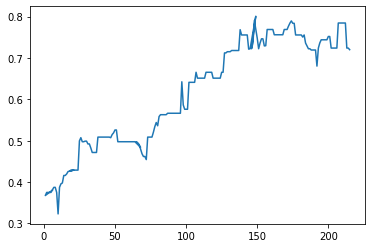

In [35]:
plt.plot(test_game["nevent"], test_game["p_W"])

In [36]:
clf_adj = CatBoostClassifier(**hpo_search.best_params_, early_stopping_rounds=100, cat_features=CATEGORICALS)
clf_adj.fit(train_df[FEATURES], train_df[TARGET], eval_set=val_pool)

0:	learn: 0.6288094	test: 0.6359478	best: 0.6359478 (0)	total: 1.18s	remaining: 19m 42s
1:	learn: 0.5853412	test: 0.5944417	best: 0.5944417 (1)	total: 2.68s	remaining: 22m 17s
2:	learn: 0.5495157	test: 0.5620870	best: 0.5620870 (2)	total: 3.95s	remaining: 21m 53s
3:	learn: 0.5217658	test: 0.5435432	best: 0.5435432 (3)	total: 5.37s	remaining: 22m 16s
4:	learn: 0.4985928	test: 0.5290020	best: 0.5290020 (4)	total: 6.56s	remaining: 21m 45s
5:	learn: 0.4818315	test: 0.5171300	best: 0.5171300 (5)	total: 7.66s	remaining: 21m 8s
6:	learn: 0.4697076	test: 0.5085527	best: 0.5085527 (6)	total: 8.96s	remaining: 21m 10s
7:	learn: 0.4570467	test: 0.5045743	best: 0.5045743 (7)	total: 10.1s	remaining: 20m 53s
8:	learn: 0.4486732	test: 0.4998462	best: 0.4998462 (8)	total: 11.5s	remaining: 21m 1s
9:	learn: 0.4394656	test: 0.4965175	best: 0.4965175 (9)	total: 12.6s	remaining: 20m 51s
10:	learn: 0.4318855	test: 0.4939019	best: 0.4939019 (10)	total: 14s	remaining: 20m 58s
11:	learn: 0.4245369	test: 0.49181

In [38]:
train_df[["p_away_team_win_new", "p_home_team_win_new"]] = clf_adj.predict_proba(train_df[FEATURES])
test_df[["p_away_team_win_new", "p_home_team_win_new"]] = clf_adj.predict_proba(test_df[FEATURES])
val_df[["p_away_team_win_new", "p_home_team_win_new"]] = clf_adj.predict_proba(val_df[FEATURES])

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
